#**Extracting sanitary checkups results from Rishon Lezion's municipal data**

"התנועה לחופש המידע"  made a freedom of information request (בקשה לחופש מידע) to Rishon Lezion municipality in order to receive this data. <br/>
More info can be found here: https://www.meida.org.il/?p=11611 <br/>

The municipality published this data in a ZIP file that contains a lot of PDFs with super generic names, like: 'דוח ביקורת (18)'. <br/>
Most of the times, you couldn't tell the resturant name from the file name. <br/>

As a citizen of Rishon Lezion I wanted to know if there are locations that I eat in that have poor sanitary. <br/>
I made this code to create an excel file to search for locations and to look on the data in an organized way. <br/>
The xlsx file that this notebook outputs (with some changes) can be found here: <br/>
https://docs.google.com/spreadsheets/d/1xXSeL0NzFHiJ-lNoXwo6rvfhVkyRTw7lyOBnxiTU4oA/edit#gid=1376681010


I'm using Tesseract OCR with some search heuristics to locate the important lines and then I'm extracting the important data from these lines. <br/>
Using Levenshtein distance was cruicial to the success of the search heuristics because the OCR isn't perfect and it might detect texts that are off by a small amount of characters compared to the original text. For example, the OCR predicts 'ט' instead of 'ם' a lot of time.

In [1]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-heb
!pip install pytesseract

!sudo apt-get install poppler-utils
!pip install pdf2image

!pip install python-Levenshtein

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,196 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [2]:
import pdf2image
import pytesseract
import glob
import Levenshtein
from tqdm import tqdm
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [3]:
# had to zip the file again on my local Windows machine because the original zip had encoding problems with Linux. The link for the new file on Google Drive is:
# https://drive.google.com/file/d/1O0-gw0eUzyaDslQDXK6vK9HwLhaE28Bz/view?usp=sharing

!gdown --id 1O0-gw0eUzyaDslQDXK6vK9HwLhaE28Bz

Downloading...
From: https://drive.google.com/uc?id=1O0-gw0eUzyaDslQDXK6vK9HwLhaE28Bz
To: /content/Sanitation-Rashletz.zip
41.2MB [00:00, 66.9MB/s]


In [4]:
!unzip Sanitation-Rashletz.zip

Archive:  Sanitation-Rashletz.zip
  inflating: דוח ביקורת (3).pdf  
  inflating: דוח ביקורת (4).pdf  
  inflating: דוח ביקורת (5).pdf  
  inflating: דוח ביקורת (6).pdf  
  inflating: דוח ביקורת (7).pdf  
  inflating: דוח ביקורת (8).pdf  
  inflating: דוח ביקורת (9).pdf  
  inflating: דוח ביקורת (10).pdf  
  inflating: דוח ביקורת (11).pdf  
  inflating: דוח ביקורת (12).pdf  
  inflating: דוח ביקורת (13).pdf  
  inflating: דוח ביקורת (14) (1).pdf  
  inflating: דוח ביקורת (14).pdf  
  inflating: דוח ביקורת (15) (1).pdf  
  inflating: דוח ביקורת (15).pdf  
  inflating: דוח ביקורת (16) (1).pdf  
  inflating: דוח ביקורת (16).pdf  
  inflating: דוח ביקורת (17) (1).pdf  
  inflating: דוח ביקורת (17).pdf  
  inflating: דוח ביקורת (18) (1).pdf  
  inflating: דוח ביקורת (18).pdf  
  inflating: דוח ביקורת (19) (1).pdf  
  inflating: דוח ביקורת (19).pdf  
  inflating: דוח ביקורת (20) (1).pdf  
  inflating: דוח ביקורת (20).pdf  
  inflating: דוח ביקורת (21) (1).pdf  
  inflating: דוח ביקורת (21).pd

In [5]:
# make sure the heb is here
print(pytesseract.get_languages(config=''))

['heb', 'eng', 'osd']


In [6]:
def prefix_lev_distance(text, prefix, tolerate):
  text_prefix = text[:len(prefix)]
  dist = Levenshtein.distance(text_prefix, prefix)
  
  return dist < tolerate


def get_images_of_pages(pdf_path):
  return pdf2image.convert_from_path(pdf_path)


def get_lines_of_page(page):
  text = pytesseract.image_to_string(page, lang="heb")
  return text.split('\n')


def get_rest_name(lines):
  INDICATOR = 'הנדון : ליקויים תברואיים בבית העסק'
  TOLERATE_INDICATOR = 4

  # these are worse indicators, but they can work if we couldn't find the first indicator
  RISKY_INDICATORS = ['מסעדת', 'מרכול']

  # we don't have the actual string that we matched, but we can skip the correct number of chars
  number_of_chars_to_skip = len(INDICATOR.replace(':', '').replace('  ', ' '))

  for line in lines:
    # sometimes 'שבבעלותך' appears and sometimes not.
    line = line.replace('שבבעלותך', '').replace('  ', ' ')
    if prefix_lev_distance(line, INDICATOR, TOLERATE_INDICATOR):
      rest_name = line.replace(':', '').replace('  ', ' ')[number_of_chars_to_skip:]

      idx_of_dash = rest_name.find('-')
      if idx_of_dash != -1:
        rest_name = rest_name[:idx_of_dash]

      return rest_name.strip()
  
  # the previous search couldn't find the name, we will try with a riskier approach
  for line in lines:
    if any(map(lambda indicator: indicator in line, RISKY_INDICATORS)):
      rest_name = line

      idx_of_dash = rest_name.find('-')
      if idx_of_dash != -1:
        rest_name = rest_name[:idx_of_dash]

      return rest_name.strip()

  return None


def get_sanitary_level(lines):
  INDICATOR = 'הרמה מבחינה "תברואית וטרינרית" שנמצאה במעמד הביקורת הינה'
  TOLERATE_INDICATOR = 4

  for line in lines:
    if prefix_lev_distance(line, INDICATOR, TOLERATE_INDICATOR):
      # the sanitary level will be the phrase after ":", it can be more than 1 word
      idx_of_colon = line.find(':')
      return line[idx_of_colon + 1:].strip()
  
  return None


def get_summary_of_findigs(lines):
  INDICATOR_FOR_START = 'עיקרי הליקויים'
  TOLERATE_INDICATOR_START = 3

  INDICATORS_FOR_END = ['העתק:', 'כתובת:']
  TOLERATE_INDICATOR_END = 2

  idx_start_line = None
  idx_end_line = None
  for line_idx, line in enumerate(lines):
    if idx_start_line is None and prefix_lev_distance(line, INDICATOR_FOR_START, TOLERATE_INDICATOR_START):
      idx_start_line = line_idx + 1    # don't include this line
    
    if idx_start_line is not None and idx_end_line is None and any(map(lambda indicator: prefix_lev_distance(line, indicator, TOLERATE_INDICATOR_END), INDICATORS_FOR_END)):
      idx_end_line = line_idx
      
      return '\n'.join(lines[idx_start_line: idx_end_line])
  
  return None

In [8]:
@dataclass
class Location:
    file_name: str
    name: str
    sanitary_level: str
    summary_of_findings: str

In [9]:
locations = []
for file_path in tqdm(glob.glob("*.pdf")):
    pages = get_images_of_pages(file_path)
    lines = get_lines_of_page(pages[0])
    
    location = Location(file_name=file_path, name=get_rest_name(lines), sanitary_level=get_sanitary_level(lines), summary_of_findings=get_summary_of_findigs(lines))
    locations.append(location)
    # print each iteration to see what is the output, it helped me tweek the extraction algorithm
    print(location)

  1%|          | 1/85 [00:05<07:30,  5.37s/it]

Location(file_name='דוח ביקורת (44).pdf', name='מסעדת חופש מול הים', sanitary_level='גרועה', summary_of_findings='במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\nמוצרים גולמיים ומוצרים מוכנים לאכילה באותו מקרר\nכמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\nראה פירוט בסוף הדו"ח\nבבית העסק לא קיימת תשתית מתאימה לעבודה עם מזון מהחי\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


  2%|▏         | 2/85 [00:09<06:41,  4.83s/it]

Location(file_name='ביקורת- 06.04.2021.pdf', name="מטעדת ג'ירף", sanitary_level='טובה', summary_of_findings='א : פרטי לבוש אישיים נמצאו בצמוד לעמדת העבודה\n\nבגדי עובדים בתא העליון במדור בשר; ציוד אישי בעמדת פס למשלוחים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


  4%|▎         | 3/85 [00:14<06:48,  4.98s/it]

Location(file_name='דוח ביקורת (29).pdf', name='אולמי סיי', sanitary_level='ירודה', summary_of_findings='תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nמוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\nבחדר הקפאה- מוצרי עוף ודגים פגי תוקף ומוצרי בשר טחון, בחלקו מבושל- הושמדו 20 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתץ אבן צור\n')


  5%|▍         | 4/85 [00:19<06:20,  4.70s/it]

Location(file_name='דוח ביקורת (7).pdf', name="מסעדת ג'ק בורגר", sanitary_level='בינוני', summary_of_findings='א : ירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\nירקות שטופים וירקות מהשדה מאוחסנים במקרר אחד\nב : מקרר- מלוכלך\nעם רוטב שנשפך בתוכו\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n')


  6%|▌         | 5/85 [00:24<06:18,  4.73s/it]

Location(file_name='דוח ביקורת 5 במאי 2021 (3).pdf', name='מסעדת פוקי בר', sanitary_level='ירודה', summary_of_findings='מזון מוכן לאכילה (מצונן) - נמדדה טמפרטורה גבוהה מהנדרש בחוק\nבאזור הדגים- פס סלטים ודגים בטמפ\' של מעל 10 מע"צ\n\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן\nמנהל השירו\n')


  7%|▋         | 6/85 [00:29<06:26,  4.89s/it]

Location(file_name='דוח ביקורת (32).pdf', name='קייטרינג סלטי משני', sanitary_level='גרועה', summary_of_findings='תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונת]/אָבן צור\n')


  8%|▊         | 7/85 [00:34<06:18,  4.85s/it]

Location(file_name='דוח ביקורת (11).pdf', name='מסעדת טוהו איזובר', sanitary_level='טובה', summary_of_findings='א + הנקיון בבית העסק לוקה בחסר\nמכונות פריסת הדגים והבשר, ציוד במקררים, מדפים במחסן, מגירות עבודה עם ציפוי (יש להסיר)\nב + במקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\n\nמוצרי עוף ובקר מאוחסנים בצמידות באותו חדר קירור\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n<< בד רב\n\nדר\' יהונתן אבן צור\nמנהל השירות\n\n/\n')


  9%|▉         | 8/85 [00:39<06:21,  4.95s/it]

Location(file_name='דוח ביקורת (23) (1).pdf', name='יוחננוף', sanitary_level=None, summary_of_findings=None)


 11%|█         | 9/85 [00:43<06:02,  4.77s/it]

Location(file_name='סלטים- סחרוב- 4.4.21.pdf', name='מסעדת סלטים', sanitary_level='ירודה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nב : קירות העסק אינם שלמים וחסרים אריחי קרמיקה\nבאזורי העבודה חסר חיפוי קרמיקה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n   \n\nאבן צור\n')


 12%|█▏        | 10/85 [00:48<05:56,  4.75s/it]

Location(file_name='דוח ביקורת (6).pdf', name='מסעזית שווארמה ראשונים', sanitary_level='ירודה', summary_of_findings=None)


 13%|█▎        | 11/85 [00:53<06:02,  4.90s/it]

Location(file_name='דוח ביקורת 24.05.2021.pdf', name='אולמי לאגו', sanitary_level='כמעט טובה', summary_of_findings='\nבמקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\n\nחלקי בשר וחלקי עוף מוכנים, הוקפאו בבית העסק - בוצעה השמדה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\nדר\' יהונתן אבן צור\n')


 14%|█▍        | 12/85 [00:58<06:06,  5.02s/it]

Location(file_name='דוח ביקורת (12).pdf', name='מטעדת פיתה בשר', sanitary_level='בינוני', summary_of_findings='א : מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nחלקי עוף טריים בקופסאות של "5 קצבים" שהוקפאו ותוקפם פג ב-11.4.2021- הושמדו 20 ק"ג\nב : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nג : חלקי בשר בשלבי הפשרה לצורך טחינה נראו מחוץ למקרר\n\nבשר טחון בהפשרה על שולחן העבודה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n->>בלהוך רב\nדר\' יהונתן אבן צור\nמנהל השיקות\n')


 15%|█▌        | 13/85 [01:04<06:07,  5.10s/it]

Location(file_name='דוח ביקורת- 03.05.2021.pdf', name='מסעדת ארומה קריית הלאוס', sanitary_level='כמעט טובה', summary_of_findings='ירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\nבחדר קירור גיבוי: במקרר שירות\nתזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nהנקיון בבית העסק לוקה בחסר\n\nפירות שטופים מאוחסנים בכלים מלוכלכים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nר\' יהונת)/אבן צור\nמנהל השירוה\n')


 16%|█▋        | 14/85 [01:07<05:36,  4.74s/it]

Location(file_name='דוח ביקורת (8).pdf', name='מטעדת פורטו מיט', sanitary_level='טובה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n    \n    \n\nמנהל השירו\n')


 18%|█▊        | 15/85 [01:12<05:26,  4.67s/it]

Location(file_name='דוח ביקורת (14).pdf', name='מסעדת בי.בי.בי.', sanitary_level='טובה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nבמקרר פס סלטים מאחסנים ביצים גולמיות ביחד עם מזון מוכן- ביצים יש לאחסן בנפרד\n\nב : בבית העסק אין זרימת מים חמים בכיורים\n\nמצ"ב דו"ת ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n \n   \n \n\nמנהל השירו')


 19%|█▉        | 16/85 [01:17<05:23,  4.69s/it]

Location(file_name='דוח ביקורת 5 במאי 2021 (2).pdf', name='מסעדת דון בורגרס', sanitary_level='גרועה', summary_of_findings='\nמזון מוכן לאכילה נמכר בטמפרטורה שאינה תקינה\n\nקופסאות עם מזון מהחי ורטבים מאוחסנות בטמפ\' החדר\n\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 20%|██        | 17/85 [01:21<05:00,  4.42s/it]

Location(file_name='דוח ביקורת (40).pdf', name='מסעדת טנדוויצ בר טוניסאי', sanitary_level='ירודה', summary_of_findings='\nא + תזרים הכנת המזון אינו תקין\n\nתכנון העסק לקוי, אין מדורים וקיימות הרבה הצטלבויות\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 21%|██        | 18/85 [01:26<05:07,  4.60s/it]

Location(file_name='דוח ביקורת (47).pdf', name='מסעדת בורגרים', sanitary_level='ירודה', summary_of_findings='א : תזרים הכנת המזון אינו תקי\n1\n\nראה פירוט בהערות כלליות סעיף 1\nב : מים חמים - אין זרימת מים חמים בכל הברזים בעסק\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nרב\n\n \n   \n\n=\nדר\' יהונתן\nמנהל השירו\n')


 22%|██▏       | 19/85 [01:30<05:09,  4.70s/it]

Location(file_name='דוח ביקורת (19) (1).pdf', name='מטעדת שניצל על הדרך', sanitary_level='גרועה', summary_of_findings='א : הנקיון בבית העסק לוקה בחסר\nבית העסק מלוכלך מאוד\nב : תזדרים הכנת המזון אינו תקין\nאין חלוקה למדורים\n\nג התשתית אינה תואמת לתוכנית שהוגשה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\nג\nר\' יהונתן אבן צור\nמנהל השי\n')


 24%|██▎       | 20/85 [01:35<05:05,  4.70s/it]

Location(file_name='דוח ביקורת (15) (1).pdf', name='מסעדת קרייזי מיט בעיימ', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nאין עבודה לפי מדורים; הפשרת בשר עופות במקרר סלטים\nב : הפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\nארגזים של עוף קפוא מחוץ למקפיא בשלבי הפשרה\nג + במקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\n\nבמקפיא- קופסאות עם בשר טחון מעובד שהוקפא- הושמדו 7.6 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n \n')


 25%|██▍       | 21/85 [01:40<04:58,  4.66s/it]

Location(file_name='דוח ביקורת (16).pdf', name='מסעדת פנטזיה', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nב : הנקין בבית העסק לוקה בחסר\n\nנעשה שימוש חוזר בקופסאות לא נקיות עם תוויות ישנות עליהן; קרשי חיתוך ופורס ביצים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n"ו תן אבן צור\n\nמנהל השרות\n')


 26%|██▌       | 22/85 [01:45<05:02,  4.80s/it]

Location(file_name='דוח ביקורת 4 במאי 2021.pdf', name='מסעדת מלך השווארמה/רד מיט', sanitary_level='כמעט טובה', summary_of_findings='תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nמוצרים נמכרים בעסק שלא לפי הוראות יצרן\n\nנעשה שימוש חוזר בשיפוד שווארמה מיום קודם\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 27%|██▋       | 23/85 [01:50<05:08,  4.97s/it]

Location(file_name='דוח ביקורת (26).pdf', name="מסעדת ג'פניקה", sanitary_level='כמעט טובה', summary_of_findings='דגים מאוחסנים ללא פתיתי קרח\n\nקלקרים ללא קרח עם דגים מאוחסנים על הרצפה מחוץ למקרר\n\nבמקרר עופות- בשר בהפשרה מתבוסס בנוזליו- יש להוציא מהאריזה לכלי עם ניקוז שמתחתיו כלי\nמזון מוכן לאכילה (מצונן) - נמדדה טמפרטורה גבוהה מהנדרש בחוק\n\nבמקרר פס לסושי נמדדה טמפ\' של 19 מע"צ\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nמנהל השירות\n')


 28%|██▊       | 24/85 [01:56<05:15,  5.17s/it]

Location(file_name='דוח ביקורת (24).pdf', name='מסעדת אגאדיר', sanitary_level='ירודה', summary_of_findings='ירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\nכיור שטיפת הירקות אינו שמיש. ירקות מהשדה נמצאים באזורים שונים במטבח ובמקררים\n\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 2\n\nבמקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר בשר נמצא גסטרונום עם בשר מוכן מבושל\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n')


 29%|██▉       | 25/85 [02:01<05:06,  5.11s/it]

Location(file_name='דוח ליקויים 17.06.2021.pdf', name='מסעדת סלטים', sanitary_level='גרועה', summary_of_findings='ביצים- איחסון הביצים מתבצע מחוץ למקרר\n\nביצים עם עובש נמצאו במגירות האחסון (פג תוקף)\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n')


 31%|███       | 26/85 [02:05<04:49,  4.91s/it]

Location(file_name='דוח ביקורת (3).pdf', name='מסעדת קפה לנדוור', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n   \n')


 32%|███▏      | 27/85 [02:11<04:52,  5.05s/it]

Location(file_name='דוח ביקורת (21).pdf', name='קייטרינג רוטי בסגנון ביתי', sanitary_level='גרועה', summary_of_findings=None)


 33%|███▎      | 28/85 [02:15<04:39,  4.90s/it]

Location(file_name='דוח ביקורת (16) (1).pdf', name='מסעדת פנטזיה', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nב : הנקין בבית העסק לוקה בחסר\n\nנעשה שימוש חוזר בקופסאות לא נקיות עם תוויות ישנות עליהן; קרשי חיתוך ופורס ביצים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n"ו תן אבן צור\n\nמנהל השרות\n')


 34%|███▍      | 29/85 [02:21<04:41,  5.02s/it]

Location(file_name='דוח ביקורת (48).pdf', name='מסעדת בורגרס בר', sanitary_level='ירודה', summary_of_findings='\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nבמקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\nהפשרת בשר בקר ועופות באותו מקרר\nבמקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבקבוקי שתיה במקרר בשר; בשר מוכן לאכילה ביחד עם ביצים ובשר מופשר\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nמנהל השירות\n')


 35%|███▌      | 30/85 [02:26<04:43,  5.16s/it]

Location(file_name='דוח ביקורת (20) (1).pdf', name='סייטרינג שולחן מלכים', sanitary_level='ירודה', summary_of_findings='א : חלק ממוצרי המזון ללא התווית תאריכי תוקף/ ייצור\n\n3 ק"ג דגי דניס ארוזים ללא תאריכים (הוקפאו בבית העסק)\n\nב יי תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nג במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר מזון בתהליך מאוחסנים בשר עופות גולמי ביחד עם מזון מוכן\n\nד : כלים ומשטחי עבודה משמשים לבשר בהמה ובעלי כנף בערבוביה\n\nבמדור בשר עובדים עם עופות\n\nה + מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nבמקרר (של עוף ובקר)- נתחי עוף פגי תוקף (הושמדו 18 ק"ג), בשר טחון, ירקות, דגים גולמיים ומזון מוכן\n')


 36%|███▋      | 31/85 [02:31<04:38,  5.16s/it]

Location(file_name='דוח ביקורת (23).pdf', name='יוחננוף', sanitary_level=None, summary_of_findings=None)


 38%|███▊      | 32/85 [02:36<04:24,  4.99s/it]

Location(file_name='דוח ביקורת 3 במאי 2021.pdf', name="מסעדת צ'יינה טאון", sanitary_level='ירודה', summary_of_findings=None)


 39%|███▉      | 33/85 [02:40<04:12,  4.85s/it]

Location(file_name='דוח ביקורת (14) (1).pdf', name='מסעדת בי.בי.בי.', sanitary_level='טובה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nבמקרר פס סלטים מאחסנים ביצים גולמיות ביחד עם מזון מוכן- ביצים יש לאחסן בנפרד\n\nב : בבית העסק אין זרימת מים חמים בכיורים\n\nמצ"ב דו"ת ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n \n   \n \n\nמנהל השירו')


 40%|████      | 34/85 [02:45<04:09,  4.89s/it]

Location(file_name='דוח ביקורת (33).pdf', name='מסעדת סלטי משני', sanitary_level='בינוני', summary_of_findings='חלק ממוצרי המזון ללא התווית תאריכי תוקף/ ייצור\nבמקרר סלטים- סלטים ללא תווית כלל, לא ברור מקורם, לא הוצגו תעודות על קבלתם או מקורם\nכמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\n\nגסטרונום עם קבב מוחזק בטמפ\' אופפת\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n₪\n\nר\' יהוגתן אבן צור\n')


 41%|████      | 35/85 [02:50<04:00,  4.81s/it]

Location(file_name='ביקורת- 03.05.2021 (2).pdf', name='מסעדת הראשון בשווארמה', sanitary_level='כמעט טובה', summary_of_findings='כמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\nשיפוד שווארמה עומד מחוץ למקרר\nתזרים הכנת המזון אינו תקין\nהפשרת בשר מתבצעת במקרר סלטים- אין מקרר ייעודי לכך; אין עבודה לפי מדורים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n,. בכבוד רב\n')


 42%|████▏     | 36/85 [02:54<03:52,  4.75s/it]

Location(file_name='דוח ליקויים 26.05.2021.pdf', name='מסעדת טינגוס', sanitary_level='בינוני', summary_of_findings='תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nהנקיון בבית העסק לוקה בחסר\nבמקרר עופות- קופסאות פלסטיק מלוכלכות ומכילות חלקי עוף\nביצים לפני בישול נמצאו בצמוד למזון מוכן לאכילה\n\nבמדור הכנת סלטים, עמדת הפס מכילה ביצים גולמיות\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nמנהל השיוקות\n')


 44%|████▎     | 37/85 [03:00<04:04,  5.10s/it]

Location(file_name='דוח ביקורת.pdf', name='מסעדת בורגר ראנץ', sanitary_level='כמעט טובה', summary_of_findings='א | : אוכל מוכן המונח בכלים שונים נראה ללא כיסוי וחשוף לזיהום\n\nבמקפיאים- המבורגרים ושניצלים חשופים\n\nב במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר הפשרות מאוחסנים ביחד רטבים, סלטים ובשר גולמי\n\nג : מזון מוכן לאכילה (מצונן) - נמדדה טמפרטורה גבוהה מהנדרש בחוק\n\nבעמדת הכנה מקוררת לסלטים- טמפ\' אופפת של 11 מע"צ\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nכבוד רב\nדר\' יהז א צור\nמנהל השיוקות\n\n/')


 45%|████▍     | 38/85 [03:04<03:40,  4.69s/it]

Location(file_name='דוח ביקורת ליקויים 16.06.2021.pdf', name='מסעדת רודיס בורגר', sanitary_level='טובה', summary_of_findings='\nא : כמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\n\nחזה עוף נמצא מחוץ למקרר\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n    \n\nמנהל השירות')


 46%|████▌     | 39/85 [03:08<03:29,  4.54s/it]

Location(file_name='דוח ביקורת (17).pdf', name='מטעדת סושיקטי', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n   \n')


 47%|████▋     | 40/85 [03:15<03:54,  5.21s/it]

Location(file_name='ביקורת- 27.05.2021.pdf', name='מסעדת קוקוטוגו', sanitary_level='גרועה', summary_of_findings='במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\nבמקרר- בשר ודגים גולמיים מאוחסנים בסמוך למזון מוכן לאכילה\nבדגים המוצגים למכירה נמדדה טמפרטורה גבוהה\n\nבתצוגה- סלמון וטונה בטמפ\' 15-16 מע"צ- הושמדו\nבמקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\nבקר גולמי פרוס שהופשר והוקפא ללא תיעוד למקור (לטענתם הובא מנאפיס)- בניגוד נהלי מ. הבריאו\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nאבן צור\n')


 48%|████▊     | 41/85 [03:20<03:44,  5.09s/it]

Location(file_name='דוח ביקורת (2).pdf', name="מסעדת ביירן סיטי בע'/מ", sanitary_level='גרועה', summary_of_findings='א במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר הפשרות- בשר טחון גולמי ביחד עם טחון מוכן לאכילה ומתובל עם רטבים\n\nב : הנקין בבית העסק לוקה בחסר\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n \n  \n\nמנהל השירו\n')


 49%|████▉     | 42/85 [03:25<03:32,  4.94s/it]

Location(file_name='דוח ביקורת ליקויים.pdf', name='מסעדת אושי אושי', sanitary_level='בינוני', summary_of_findings='תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 51%|█████     | 43/85 [03:30<03:29,  5.00s/it]

Location(file_name='דוח ביקורת (42).pdf', name='מסעדת טורו גריל', sanitary_level='ירודה', summary_of_findings='\nהפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\n\nבטמפ\' אופפת של 27 מע"צ\n\nבמקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\n\nבחדר ההקפאה- מוצרי ב.ע.ד.- הושמדו 10 ק"ג\n\nהנקיון בבית העסק לוקה בחסר\n\nראה פירוט בהערות כלליות סעיף 2\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן\nמנהל השירו\n')


 52%|█████▏    | 44/85 [03:35<03:30,  5.13s/it]

Location(file_name='דוח ביקורת 5 במאי 2021 (4).pdf', name='מסעדת שגב אקספרס', sanitary_level='כמעט טובה', summary_of_findings='דגים/מוצריהם נמצאו בטמפרטורה גבוהה מהמותר מחוץ למקרר\nבחדר עבודה דגים- כמות גדולה של דגים בטמפ\' של 10 מע"צ\nירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\nירקות לא שטופים בעמדת חיתוך ירקות ובחדר קירור ירקות\nכלים ומשטחי עבודה משמשים לבשר בהמה ובעלי כנף בערבוביה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן\nמנהל השירות\n')


 53%|█████▎    | 45/85 [03:40<03:23,  5.09s/it]

Location(file_name='דוח ביקורת (13).pdf', name='מסעדת אלעד הבאגט (יוסי)', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nאין עבודה לפי מדורים; תהליך הכנת המזון אינו תקין\n\nב : במקרר- בשר בהפשרה מתבוסס בנוזליו- יש להפשיר בגסטרונום מרושת עם כלי לאיסוף הנוזלים\nג : מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nחלקי עוף- הושמדו 4 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבוד רב\n\' יהותן אמ צור\n\nמנהל ה')


 54%|█████▍    | 46/85 [03:44<03:09,  4.87s/it]

Location(file_name='דוח ביקורת 5 במאי 2021.pdf', name='מסעדת בהדונסי', sanitary_level='גרועה', summary_of_findings='עבודה וקבלת אספקת בשר בצורה לא תקינה- ראה פירוט בהערות כלליות סעיף 1\n1 1 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 55%|█████▌    | 47/85 [03:49<02:59,  4.72s/it]

Location(file_name='דוח ביקורת (49).pdf', name='סטופ מרקט', sanitary_level='טובה', summary_of_findings='מזון מוכן לאכילה (מצונן) - נמדדה טמפרטורה גבוהה מהנדרש בחוק\n\nבמקרר פס סלטים- מוצרים בטמפ\' של 13 מע"צ וטמפ\' המקרר 7 מע"צ\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן\n\nמנהל השירו')


 56%|█████▋    | 48/85 [03:55<03:12,  5.20s/it]

Location(file_name='דוח ביקורת (34).pdf', name='חצי חינם', sanitary_level=None, summary_of_findings='בבית העסק נעשות פעולות יצרניות בניגוד לתנאי הרישיון\nנמצאו קרטונים לאריזת ביצים; במקררי השרות- כמויות של גבינות ונקניקים שגורדו/נפרסו מראש\nתהליכי זרימת מוצרי מזון בבית העסק לקויים\nראה פירוט בסוף הדו"ח\n\nאת הליקויים יש לתקן תוך שבועיים מיום קבלתך מכתב זה.\nבמידה ולא יתוקנו הליקויים כאמור נאלץ לנקוט נגדך בכל האמצעים החוקיים העומדים לרשותנו.\n\nדר\' יהונוץ אבן צור\n')


 58%|█████▊    | 49/85 [04:00<03:05,  5.16s/it]

Location(file_name='דוח ביקורת (28).pdf', name='מסעדת סוסו אנד סאנט', sanitary_level='כמעט טובה', summary_of_findings='חלקי עוף בהפשרה מתבוססים בנוזליהם- יש להניח בכלי מרושת עם כלי נוסף מתחתיו לקליטת\nתזרים הכנת המזון אינו תקין\n\nבמדור עבודה עם בשר גולמי נמצאה פלטת חימום\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\nדר\' יהונתן אבן צור\n')


 59%|█████▉    | 50/85 [04:06<03:07,  5.35s/it]

Location(file_name='דוח ביקורת- 30.06.2021.pdf', name='מסעדת קמפניה', sanitary_level='גרועה', summary_of_findings='בשר ממקור לא מאושר- ראה פירוט בהערות כלליות סעיף 2\n\nתזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nבמקרר נמצאו קרטונים עם עופות / חלקי עופות ללא התוויה כנדרש בחוק\n\nבשר בקר ללא התוויה וסימון- הושמדו 60 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\nמנהל השיר\n')


 60%|██████    | 51/85 [04:09<02:41,  4.76s/it]

Location(file_name='דוח ביקורת (46).pdf', name='אולמי תרין', sanitary_level='טובה', summary_of_findings=None)


 61%|██████    | 52/85 [04:14<02:33,  4.65s/it]

Location(file_name='דוח ביקורת (22).pdf', name=None, sanitary_level=None, summary_of_findings='מים חמים - אין זרימת מים חמים בבית העסק\n\nאת הליקויים יש לתקן תוך שבועיים מיום קבלתך מכתב זה.\nבמידה ולא יתוקנו הליקויים כאמור נאלץ לנקוט נגדך בכל האמצעים החוקיים העומדים לרשותנו.\n\nבכבוד רב\n')


 62%|██████▏   | 53/85 [04:18<02:24,  4.52s/it]

Location(file_name='דוח ביקורת 7 ביוני 2021.pdf', name='סייטרינג ברכה משולשת', sanitary_level='טובה מאוד', summary_of_findings='הנקיון בבית העסק לוקה בחסר\n\nפותחן קופסאות חשמלי מלוכלך בחדר עבודה סלטים; מטחנה תעשייתית מלוכלכת\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונקן אבן צור\nמנהל השיוקות')


 64%|██████▎   | 54/85 [04:23<02:22,  4.61s/it]

Location(file_name='דוח ביקורת (18) (1).pdf', name='מטעדת ישר לפיתה', sanitary_level='בינוני', summary_of_findings='א : אין התאמה בין התוכנית למצב הנמצא בשטח\nב נמצאו מוצרים מהחי (בשר בהמות) ללא תעודות המעידות על מקורם ואף לא אותרו במערכת\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n    \n \n\nמנהל השיוקות\n')


 65%|██████▍   | 55/85 [04:28<02:27,  4.90s/it]

Location(file_name='דוח ליקויים 10.05.2021.pdf', name='מסעדת נאפיס חולון', sanitary_level='כמעט טובה', summary_of_findings='\nהפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\n\nבמדור בקר\n\nבמקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\nמקרר הפשרה משותף\nבמקום נראו מוצרי ב.ע.ד מופשרים בכיור עם מים\n\nמקרר דגים-הפשרת דגים בתוך שקית, לא קיימת רשת לניקוז הנוזלים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\nאבן צור\n')


 66%|██████▌   | 56/85 [04:33<02:20,  4.84s/it]

Location(file_name='דוח ביקורת (43).pdf', name='מסעדת ריבר נודלס בר', sanitary_level='בינוני', summary_of_findings='תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nבמקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\n\nבמקרר הפשרה עופות נמצאו המבורגרים מבשר בהמות\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 67%|██████▋   | 57/85 [04:38<02:17,  4.89s/it]

Location(file_name='דוח ביקורת 4 במאי 2021 (3).pdf', name='מסעדת במבו', sanitary_level='בינוני', summary_of_findings='במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\nעוף מוכן לאכילה במקרר עוף גולמי- הושמד ע"י הבעלים\nירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\nירקות לא שטופים נמצאו במדור חיתוך ירקות ובמקרר סלטים\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nר\' יהונתן/אבן צור\nמנהל השירו\n')


 68%|██████▊   | 58/85 [04:42<02:02,  4.54s/it]

Location(file_name='דוח ביקורת (45).pdf', name='מסעדת מוזס', sanitary_level='כמעט טובה', summary_of_findings=None)


 69%|██████▉   | 59/85 [04:46<01:55,  4.43s/it]

Location(file_name='דוח ביקורת (17) (1).pdf', name='מטעדת סושיקטי', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n   \n')


 71%|███████   | 60/85 [04:51<01:52,  4.49s/it]

Location(file_name='ביקורת- 03.05.2021.pdf', name='מסעדת הראשון בשווארמה', sanitary_level='כמעט טובה', summary_of_findings='כמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\nשיפוד שווארמה עומד מחוץ למקרר\nתזרים הכנת המזון אינו תקין\nהפשרת בשר מתבצעת במקרר סלטים- אין מקרר ייעודי לכך; אין עבודה לפי מדורים\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n,. בכבוד רב\n')


 72%|███████▏  | 61/85 [04:56<01:51,  4.64s/it]

Location(file_name='עזרא ובניו סחרוב- 4.4.21.pdf', name='מסעדת שיפודי עזרא ובניו', sanitary_level='ירודה', summary_of_findings='\nא : תזרים הכנת המזון אינו תקין\n\nבמדור עופות עובדים עם בשר בקר\nב : בבית העסק מתבצעת פעילות ללא תשתית מתאימה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n \n')


 73%|███████▎  | 62/85 [05:00<01:45,  4.61s/it]

Location(file_name='דוח ליקויים 10.05.2021 (2).pdf', name='מסעדת שווארמה גריל בר', sanitary_level='בינוני', summary_of_findings=None)


 74%|███████▍  | 63/85 [05:06<01:47,  4.89s/it]

Location(file_name='ביקורת- 01.06.2021.pdf', name='מסעדת החוף הדרומי', sanitary_level='גרועה', summary_of_findings='במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבבית העסק חדר קירור אחד בו מאוחסנים ביחד מוצרים גולמיים ומוכנים\n\nתזרים הכנת המזון אינו תקין\n\nבחדר הקירור מאוחסנים ביחד מזון מוכן, מזון גולמי, ירקות שטופים ומהשדה, ביצים וגבינות\n\nמוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nבחדר הקירור נמצא סלט טונה עם מיונז מתאריך 25.5.2021- נזרק לפח\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n< = דר יהונתן אבן צור\n')


 75%|███████▌  | 64/85 [05:10<01:42,  4.87s/it]

Location(file_name='דוח ביקורת (18).pdf', name='מטעדת ישר לפיתה', sanitary_level='בינוני', summary_of_findings='א : אין התאמה בין התוכנית למצב הנמצא בשטח\nב נמצאו מוצרים מהחי (בשר בהמות) ללא תעודות המעידות על מקורם ואף לא אותרו במערכת\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n    \n \n\nמנהל השיוקות\n')


 76%|███████▋  | 65/85 [05:16<01:38,  4.93s/it]

Location(file_name='שגב קונספט- ילדי טהרן- 5.4.21.pdf', name='מטעדת שגב קונספט', sanitary_level='גרועה', summary_of_findings='א : מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nמוצרי עוף במקרר מזון בתהליך; המבורגרים במקרר פס\n\nב : במקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n   \n \n\nאבן צור\nמנהל השי\n')


 78%|███████▊  | 66/85 [05:20<01:32,  4.89s/it]

Location(file_name='דוח ביקורת (4).pdf', name='מטעדת לחם ארל', sanitary_level='לקויה', summary_of_findings='א מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\nבמקפיא- נתחי עוף פגי תוקף- הושמדו 60 ק"ג\nב + תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n  \n\nמנהל השילות\n')


 79%|███████▉  | 67/85 [05:25<01:24,  4.68s/it]

Location(file_name='ביקורת- 03.05.2021 (3).pdf', name='מסעדת ניו דלהי', sanitary_level='טובה מאוד', summary_of_findings='תזרים הכנת המזון אינו תקין\nעגבניות לאחר שטיפה מלוכלכות- יש להסיר את "העוקץ" בזמן השטיפה מחשש לזיהום\nבבית העסק אין זרימת מים חמים בכיורים\nכיורים ללא סבון נוזלי\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n')


 80%|████████  | 68/85 [05:29<01:20,  4.74s/it]

Location(file_name='דוח ביקורת (50).pdf', name='מסעדת שווארמה על הים', sanitary_level='ירודה', summary_of_findings='חלק ממוצרי המזון ללא התווית תאריכי תוקף/ ייצור\nמוצרי בשר ודגים, טריים וקפואים, ללא התוויה; במקפיא- שיפודי שווארמה, פיתות ודגים\nתזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן אאן צור\nמנהל השירות\n')


 81%|████████  | 69/85 [05:35<01:19,  4.96s/it]

Location(file_name='דוח ביקורת (25).pdf', name='ק מסעדת פוד טרמינל', sanitary_level='בינוני', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nב : מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\nבשר קפוא פג תוקף- הושמדו 43 ק"ג; עופות, חלב\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n \n')


 82%|████████▏ | 70/85 [05:40<01:16,  5.08s/it]

Location(file_name='דוח ביקורת (21) (1).pdf', name='קייטרינג רוטי בסגנון ביתי', sanitary_level='גרועה', summary_of_findings=None)


 84%|████████▎ | 71/85 [05:46<01:12,  5.18s/it]

Location(file_name='דוח ביקורת (20).pdf', name='סייטרינג שולחן מלכים', sanitary_level='ירודה', summary_of_findings='א : חלק ממוצרי המזון ללא התווית תאריכי תוקף/ ייצור\n\n3 ק"ג דגי דניס ארוזים ללא תאריכים (הוקפאו בבית העסק)\n\nב יי תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nג במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר מזון בתהליך מאוחסנים בשר עופות גולמי ביחד עם מזון מוכן\n\nד : כלים ומשטחי עבודה משמשים לבשר בהמה ובעלי כנף בערבוביה\n\nבמדור בשר עובדים עם עופות\n\nה + מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nבמקרר (של עוף ובקר)- נתחי עוף פגי תוקף (הושמדו 18 ק"ג), בשר טחון, ירקות, דגים גולמיים ומזון מוכן\n')


 85%|████████▍ | 72/85 [05:51<01:09,  5.33s/it]

Location(file_name='דוח ביקורת (36).pdf', name='אולמי פראיסו', sanitary_level='ירודה', summary_of_findings='\nבמקום נראו מוצרי ב.ע.ד מופשרים בכיור עם מים\n\nמוצרי ב.ע.ד.\n\nבמקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\n\nבמקרר עופות נמצאו בשר בקר ובצקים- יש לאחסן לפי הנהלים\n\nתזרים הכנת המזון אינו תקין\n\nבשר בקר ועופות נמצא ביחד בהפשרה; אין עבודה לפי מדורים\n\nבמקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן לאכילה\n\nבמקרר עם בשר עוף מוכן לאכילה מאוחסן גם בשר בקר גולמי\n')


 86%|████████▌ | 73/85 [05:57<01:03,  5.29s/it]

Location(file_name='דוח ביקורת (9).pdf', name='מסעדת קוקה קולה', sanitary_level='טובה', summary_of_findings='א : הנקיון בבית העסק לוקה בחסר\nגסטרונומים לאחר שטיפה עם מדבקות ישנות- יש להקפיד להסיר; שימוש חוזר בארגזי ירקות מלוכלכים\nב : במקרר נמצאו קרטונים עם עופות / חלקי עופות ללא התוויה כנדרש בחוק\n\nאין עקיבות- במקרר הפשרה נמצאו עופות בגסטרונומים עם מדבקות של בשר בקר\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n    \n \n\n \n  \n\nר\' יהונתן צור\n\nמנהל השירות\n')


 87%|████████▋ | 74/85 [06:01<00:56,  5.13s/it]

Location(file_name='דוח ליקויים 27.05.2021.pdf', name='מסעדת הברברי', sanitary_level='טובה', summary_of_findings='ניקוז כיור שטיפת ירקות, לא מחובר לתעלה והמים זורמים על הרצפה\nנעשה שימוש במיכלים המיועדים לשימוש חד פעמי, שלא נוקו כראוי\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n> בכבוד רב\n')


 88%|████████▊ | 75/85 [06:07<00:53,  5.34s/it]

Location(file_name='דוח ביקורת (35).pdf', name='מסעדת מיזו סושי בר', sanitary_level='גרועה', summary_of_findings='מוצרים נמכרים בעסק שלא לפי הוראות יצרן\n\nכמות גדולה של שניצלונים נמצאה מחוץ לבית העסק- הושמדו 20 ק"ג; רטבים פתוחים מאוחסנים ללא\n\nחלק ממוצרי המזון ללא התווית תאריכי תוקף/ ייצור\n\nבמקרר סלטים- מוצרי מזון שונים בקופסאות ממוחזרות ללא התוויה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n= דר\' יהונתן\nמנהל השירות\n')


 89%|████████▉ | 76/85 [06:12<00:48,  5.34s/it]

Location(file_name='דוח ביקורת (37).pdf', name='אולמי סאקורה', sanitary_level='ירודה', summary_of_findings='ירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד למזון מוכן לאכילה\n\nבמקרר\n\nביצים לפני בישול נמצאו בצמוד למזון מוכן לאכילה\nבמקרר ביצים- ביצים גולמיות ביחד עם סלטים\nבמקפיא התצוגה נמצא מוצרים בתהליך הפשרה\n\nמזון מוכן לאכילה ובשר גולמי שהפשירו- הושמדו 15 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן אבן צור\nמנהל השיר\n')


 91%|█████████ | 77/85 [06:17<00:41,  5.22s/it]

Location(file_name='דוח ביקורת (5).pdf', name="מסעדת קינג ג'ורג'", sanitary_level='ירודה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\n\nראה פירוט בהערות כלליות סעיף 1\n\nב : הפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\n\nהפשרת דגים מתבצעת על שולחן העבודה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nרב\n\n  \n   \n \n\nדר\' יהונ\nמנהל השי\n\nאבן צור\n')


 92%|█████████▏| 78/85 [06:21<00:34,  4.87s/it]

Location(file_name='דוח ביקורת 4 במאי 2021 (2).pdf', name='מסעדת ריו', sanitary_level='בינוני', summary_of_findings='תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 1\nהנקיון בבית העסק לוקה בחסר\n\nלכלוך מתחת לדלפק בעמדת פס ההכנות; בית העסק מאוד מלוכלך ומבולגן\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nדר\' יהונתן\nמנהל השירות\n')


 93%|█████████▎| 79/85 [06:26<00:28,  4.75s/it]

Location(file_name='דוח ביקורת (10).pdf', name='מסעדת לחם בשר', sanitary_level='בינוני', summary_of_findings='א : במקרר האיחסון בשר בהמה ובעלי כנף מאוחסנים בצמידות\nמקרר משותף לעוף ולבשר\nב : תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כלליות סעיף 2\nג + מוצרי מזון אשר תוקף חיי המדף שלהם פג נמצאו בבית העסק\n\nבמקרר דגים- סלמון פג תוקף בהפשרה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\n8 רב\n\' יְהוְּתֶן אבן צור\nמנהל השיוקות\n')


 94%|█████████▍| 80/85 [06:31<00:24,  4.82s/it]

Location(file_name='דוח ביקורת (27).pdf', name="מסעדת א.צ'יקן ברוסטר", sanitary_level='לקויה', summary_of_findings='תזרים הכנת המזון אינו תקין\nאין מדורים ותהליכי העבודה אינם תקניים\nבמקום נראו מוצרי ב.ע.ד מופשרים בכיור עם מים\nעופות בהפשרה מונחים בגסטרונומים עם מים\n\nהפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nמנהל השירו\n')


 95%|█████████▌| 81/85 [06:35<00:18,  4.68s/it]

Location(file_name='דוח ביקורת (22) (1).pdf', name=None, sanitary_level=None, summary_of_findings='מים חמים - אין זרימת מים חמים בבית העסק\n\nאת הליקויים יש לתקן תוך שבועיים מיום קבלתך מכתב זה.\nבמידה ולא יתוקנו הליקויים כאמור נאלץ לנקוט נגדך בכל האמצעים החוקיים העומדים לרשותנו.\n\nבכבוד רב\n')


 96%|█████████▋| 82/85 [06:39<00:13,  4.52s/it]

Location(file_name='ביקורת- 24.05.2021.pdf', name=None, sanitary_level='בינוני', summary_of_findings='ביצים לפני בישול נמצאו בצמוד למזון מוכן לאכילה\n\nבחדר הקירור מאוחסנים ביחד ביצים, רטבים ושתיה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nמנהל השירו\n')


 98%|█████████▊| 83/85 [06:44<00:09,  4.63s/it]

Location(file_name='דוח ביקורת (41).pdf', name='אולמי בלוודר', sanitary_level='בינוני', summary_of_findings='א : מקקים נראו בבית העסק\n\nמקק נראה בחדר העבודה\n\nב : כמות גדולה של חומר גלם המיועד לעיבוד, מוחזקת זמן רב מחוץ למקרר\n\nנתחי בקר על שולחן העבודה ללא קירור\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n')


 99%|█████████▉| 84/85 [06:49<00:04,  4.68s/it]

Location(file_name='דוח ביקורת (15).pdf', name='מסעדת קרייזי מיט בעיימ', sanitary_level='לקויה', summary_of_findings='א : תזרים הכנת המזון אינו תקין\nאין עבודה לפי מדורים; הפשרת בשר עופות במקרר סלטים\nב : הפשרת הבשר בהמה/ בעלי כנף ודגים מתבצעת מחוץ למקרר\nארגזים של עוף קפוא מחוץ למקפיא בשלבי הפשרה\nג + במקפיא נמצאו חבילות עם חלקי בשר שנארזו והוקפאו בבית העסק\n\nבמקפיא- קופסאות עם בשר טחון מעובד שהוקפא- הושמדו 7.6 ק"ג\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\n \n')


100%|██████████| 85/85 [06:54<00:00,  4.88s/it]

Location(file_name='דוח ביקורת (19).pdf', name='מטעדת שניצל על הדרך', sanitary_level='גרועה', summary_of_findings='א : הנקיון בבית העסק לוקה בחסר\nבית העסק מלוכלך מאוד\nב : תזדרים הכנת המזון אינו תקין\nאין חלוקה למדורים\n\nג התשתית אינה תואמת לתוכנית שהוגשה\n\nמצ"ב דו"ח ובו פירוט הליקויים שנמצאו בביקורת והערות לתיקון.\n\nבכבוד רב\n\nג\nר\' יהונתן אבן צור\nמנהל השי\n')


That's good enough for now, we will now fix some of them manually.

In [10]:
def get_file_names_of_nones_in_cat(locations, getter):
  return [location.file_name for location in locations if getter(location) is None]


def fix_locations_in_cat(locations, setter, mapping):
  for file_name_of_mapping, new_val in mapping.items():
    # we got a small amount of locations, so we can do O(N^2)
    for location in locations:
      if location.file_name == file_name_of_mapping:
        setter(location, new_val)

In [11]:
get_file_names_of_nones_in_cat(locations, lambda loc: loc.name)

['דוח ביקורת (22).pdf', 'דוח ביקורת (22) (1).pdf', 'ביקורת- 24.05.2021.pdf']

In [12]:
def name_setter(location, new_val):
  location.name = new_val


mapping_for_name = {
    'דוח ביקורת (22).pdf': 'יוחננוף מזון מוכן',
    'דוח ביקורת (22) (1).pdf': 'יוחננוף מזון מוכן',
    'ביקורת- 24.05.2021.pdf': 'אולמי סואול'
}

fix_locations_in_cat(locations, name_setter, mapping_for_name)
assert len(get_file_names_of_nones_in_cat(locations, lambda loc: loc.name)) == 0

In [13]:
get_file_names_of_nones_in_cat(locations, lambda loc: loc.sanitary_level)

['דוח ביקורת (23) (1).pdf',
 'דוח ביקורת (23).pdf',
 'דוח ביקורת (34).pdf',
 'דוח ביקורת (22).pdf',
 'דוח ביקורת (22) (1).pdf']

In [14]:
def sanitray_level_setter(location, new_val):
  location.sanitary_level = new_val


mapping_for_sanitary_level = {
    'דוח ביקורת (23) (1).pdf': 'כמעט טובה',
    'דוח ביקורת (23).pdf': 'כמעט טובה',
    'דוח ביקורת (34).pdf': 'בינוני',
    'דוח ביקורת (22).pdf': 'טובה מאוד',
    'דוח ביקורת (22) (1).pdf': 'טובה מאוד'
}

fix_locations_in_cat(locations, sanitray_level_setter, mapping_for_sanitary_level)
assert len(get_file_names_of_nones_in_cat(locations, lambda loc: loc.sanitary_level)) == 0

In [15]:
sanitary_counter = Counter([loc.sanitary_level for loc in locations])

sanitary_counter

Counter({'בינוני': 16,
         'גרועה': 15,
         'טובה': 10,
         'טובה מאוד': 4,
         'ירודה': 17,
         'כמעט טובה': 13,
         'לקויה': 10})

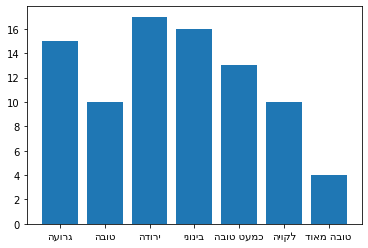

In [16]:
plt.bar([key[::-1] for key in sanitary_counter.keys()], sanitary_counter.values())
plt.show()

Most of the locations have "ירודה" sanitary level...

We will fix the missing summaries on the excel file itself after the export.

In [17]:
data_dict = {
    'file_name': [loc.file_name for loc in locations],
    'business_name': [loc.name for loc in locations],
    'sanitary_level': [loc.sanitary_level for loc in locations],
    'summary_of_findings': [loc.summary_of_findings for loc in locations]
}

df = pd.DataFrame(data_dict)

df.head()

,file_name,business_name,sanitary_level,summary_of_findings
0,דוח ביקורת (44).pdf,מסעדת חופש מול הים,גרועה,במקרר איחסון מאחסנים בצמוד בשר טרי ומזון מוכן ...
1,ביקורת- 06.04.2021.pdf,מטעדת ג'ירף,טובה,א : פרטי לבוש אישיים נמצאו בצמוד לעמדת העבודה\...
2,דוח ביקורת (29).pdf,אולמי סיי,ירודה,תזרים הכנת המזון אינו תקין\nראה פירוט בהערות כ...
3,דוח ביקורת (7).pdf,מסעדת ג'ק בורגר,בינוני,א : ירקות/ פירות מהשדה (לא שטופים) נמצאו בצמוד...
4,דוח ביקורת 5 במאי 2021 (3).pdf,מסעדת פוקי בר,ירודה,מזון מוכן לאכילה (מצונן) - נמדדה טמפרטורה גבוה...


In [18]:
df.to_excel('rishon_lezion_sanitary.xlsx', index=False)